# 1. Intro

**FAQ style retrieval based chat bot**
- Train three model types (in different configurations) to figure out user input and map to a response class. Let's see which one does well. The models are
    - a TF-IDF similarity measure doc classifier 
    - a TFIDF based n-gram MLP multi-class classifier (supervised)
    - an RNN classifier (unsupervised)

**The Data**
- Pulling data from known disease/pandemic authorities such as CDC and WHO

- Also getting KE national government content. These are static data; knowledge already in place. TODO: a channel for news updates 

- Data is maintained in a Gsheet and can make updates/additions/etc from there

- Clean and classify the above data to have two datasets
    - FAQ_db: This is the knowledge base. One to one mapping of class categories and response paragraphs. Has two main fields: class_category, response_p. Additional fields: src, src_link 
    - Phrases_db: This is the training set on questions/input that users may present to the bot. Has two main fields: input_phrase, class_category 
    
**Approach**
- Retrieval based chat bot. 


# 2. Corana Dashboard by John Hopkins Uni

[Link to map FAQ](https://coronavirus.jhu.edu/map-faq)

In [1]:
### John Hopkins Dashboard - https://coronavirus.jhu.edu/map.html
from IPython.display import IFrame
## default 77.3846,11.535 
start_coordz = "77.3846,11.535"  # rabat, morocco"33.9693414,-6.9273026"
center_coordz = "28.8189834,-2.5117154" #center Bukavu, DRC "-2.5117154,28.8189834"

IFrame(src="//arcgis.com/apps/Embed/index.html?webmap=14aa9e5660cf42b5b4b546dec6ceec7c&extent="+start_coordz+",163.5174,52.8632"+
       "&center="+center_coordz+
       "&zoom=true&previewImage=false&scale=true&disable_scroll=true&theme=light", 
    width="650", height="400", frameborder="0", scrolling="no", marginheight="0", marginwidth="0", title="2019-nCoV" )

# 3. FAQ Chat bot

## 3.1. Explore the data 

In [2]:
import numpy as np
import pandas as pd

import nltk

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [3]:
import sys
sys.path.append("../../../shared") 
import zdataset, zdata_source
from zdataset import ZGsheetFaqDataSet


import warnings
warnings.filterwarnings('ignore')

In [20]:
## plot settings
params = {
    'font.size' : 10.0,
    'figure.figsize': (20.0, 12.0),
    'figure.dpi' : 40
}
plt.rcParams.update(params)
plt.style.use('fivethirtyeight') #tableau-colorblind10 ggplot

In [24]:
## some helper functions @ view db

## requires zdataset object . Forcing Abstract vs gsheet subclass<< TODO reflection at abstract class
def preview_gsheet_faq(db):
    ### What does an faq response record look like
    try:
        k= list(db.faq_db.keys())[0]
        v = db.faq_db[ k ] 
        print( "FAQ db Item: (k ==> v)" )
        print("{} ==> {}".format( k, v   ) )
    except:
        pass
    ### What does a phrase record look like
    try:
        k = list(db.data.keys())[0]
        v = db.data[ k ] 
        print("\n\nPhrases db Item: (k ==> v)") 
        print("{} ==> {}".format( k, v   ) )
    except:
        k = 0
        v = db.data[ k ] 
        print("\n\nPhrases db Item: (k ==> v)") 
        print("{} ==> {}".format( k, v   ) )
        

def show_basic_stats(db_wordz, db_lemmaz, vocab_wordz, vocab_lemmaz):
    print( "1. Wordz: count = {}, sample = {}".format( len(db_wordz), db_wordz[:4]))
    print( "2. Lemmaz: count = {}, sample = {}".format( len(db_lemmaz), db_lemmaz[:4]))

    print( "3. Vocab Wordz: count = {}, sample = {}".format( len(vocab_wordz), vocab_wordz[:4]))
    print( "4. Vocab Lemmaz: count = {}, sample = {}".format( len(vocab_lemmaz), vocab_lemmaz[:4]))

    # lexical diversity
    print( "5. Lemmaz/Wordz ratio = {}".format( len(db_lemmaz) / len(db_wordz) ))
    print( "6. Vocab/Wordz ratio = {}".format(  len(vocab_wordz) / len(db_wordz) ) ) 
    print( "7. Vocab/Lemmaz ratio = {}".format( len(vocab_lemmaz)/len(db_lemmaz) ) )
    
## given a sequence do FreqDist and report
def doFreqDist( list_text ):
    fq = nltk.FreqDist( list_text )
    print( "FreqDist of {} tokens.".format( fq.N() ) )
    print( "Top 10 common tokens: \n{}".format( fq.most_common(10) ) )
    # plot most common
    fq.plot( 15) 
    return fq

## plot multiple seqence in same 
def fq_plotMultiple(fqz, namez):
    colz = ['token', 'freq']    
    
    df = pd.DataFrame( fqz[0].most_common(10), columns=['token', 'freq'])
    df['dset'] = namez[0]
    
    for i, fq in enumerate(fqz[1:]):        
        j = i+1
        tmp = pd.DataFrame( fq.most_common(10), columns=['token', 'freq'])
        tmp['dset'] = namez[j] 
        df = pd.concat([df, tmp])
#         print( "{}: shape: {}, columns: {} Sample: \n{}".format(namez[j], tmp.shape, tmp.columns, tmp.head(2), )) 
    
    print( "FIN>>> shape: {}, columns: {} Sample: \n{}".format( df.shape, df.columns, df.head(2), )) 
    
    g = sns.barplot( x='token', y='freq', hue='dset', dodge=False, data=df)
    g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right')
#     plt.xticks( rotation = 45)
    plt.show()

In [5]:
print('nb.load_data', "Loading Gsheet FAQ db")
faq_path = [ ('1EuvcPe9WXSQTsmSqhq0LWJG4xz2ZRQ1FEdnQ_LQ-_Ks', 'FAQ responses!A1:G1000'), ('1EuvcPe9WXSQTsmSqhq0LWJG4xz2ZRQ1FEdnQ_LQ-_Ks', 'Classify_Phrases!A1:G1000')]
faq_typ = zdata_source.zGSHEET_FAQ


dset = ZGsheetFaqDataSet()
dset.initFromResource(faq_path, faq_typ)  
dset.preprocess()     
dlen =  len(dset.clean_data) 
print( "Tokens len: {}\n{}\n".format(dlen, dset.clean_data[: min(dlen, 10) - 1 ] ) ) 

nb.load_data Loading Gsheet FAQ db
Tokens len: 1207
['what' 'is' 'a' 'pandemic' 'what' 'cause' 'pandemic' 'what' 'doe']



In [6]:
### What does an faq response and phrase record look like
preview_gsheet_faq(dset)

FAQ db Item: (k ==> v)
pandemic_define ==> ['A pandemic is an epidemic (infectious disease outbreak) that spreads on a global scale. Pandemics usually occur when a new infectious disease emerges that can spread rapidly around the world.\r\n\r\nThe World Health Organization (WHO) declared the outbreak of COVID-19 a pandemic on 11 March 2020. This COVID-19 pandemic is the first caused by a coronavirus. (WHO)', 'Australian Govt', 'https://www.health.nsw.gov.au/Infectious/alerts/Pages/coronavirus-faqs.aspx#8-1']


Phrases db Item: (k ==> v)
what is a pandemic? ==> pandemic_define


## Preprocessing & Stats on the data

Data refers to the phrases, on which user input is determined. 

**Preprocessing**
- Clean: words to lower, remove punkts, keep numbers.
- Option to lemmatize or use phrases as is.



**Data Stats** 
- number of records, train Vs test
- lexical diversity, train Vs test 
- 


In [7]:
### clean_data_and_lemmatize Vs no lemmatized.
## at this point it's just bag of words. @model can decide if BOW or Sequence
###### UPDATES after EDA rounds
## - remove stop words and numbers

dict_preprocess_argz = {
    'remove_stopwordz' : True, 
    'remove_numberz' : True
}

## 1. no_lemmatization
dset.preprocess( lemmatized=False, **dict_preprocess_argz )
db_wordz = dset.clean_data
vocab_wordz = dset.getVocab()

## 2. yes lemmatization 
dset.preprocess( lemmatized=True, **dict_preprocess_argz)
db_lemmaz = dset.clean_data
vocab_lemmaz = dset.getVocab()

## 3. Show full db stats
show_basic_stats(db_wordz, db_lemmaz, vocab_wordz, vocab_lemmaz)

## 4. Split train and test 
print( "Size = {}".format( len(dset.clean_data) ) )
db_train, db_test = dset.splitIntoTrainTest()

## 3. Show train, test stats
for i, db in enumerate([db_train, db_test]) :
    print("\n {0} {1} Dataset {0}".format("-"*5, "train" if i == 0 else "test"))
#     preview_gsheet_faq(db)
    print( "Size = {}".format( len(db.data) ) )
    
    ## 1. no_lemmatization
    db.preprocess( lemmatized=False, **dict_preprocess_argz)
    db_wordz = db.clean_data
    vocab_wordz = db.getVocab()

    ## 2. yes lemmatization 
    db.preprocess( lemmatized=True, **dict_preprocess_argz)
    db_lemmaz = db.clean_data
    vocab_lemmaz = db.getVocab()
    
    show_basic_stats(db_wordz, db_lemmaz, vocab_wordz, vocab_lemmaz)



INFOR   : 2020-04-04 17:45:53.302376 [splitTrainTest] Provided data size = 510
pandemic


1. Wordz: count = 509, sample = ['pandemic' 'causes' 'pandemics' 'mean']
2. Lemmaz: count = 509, sample = ['pandemic' 'cause' 'pandemic' 'mean']
3. Vocab Wordz: count = 267, sample = ['access' 'adhere' 'adults' 'affected']
4. Vocab Lemmaz: count = 251, sample = ['access' 'adhere' 'adult' 'affected']
5. Lemmaz/Wordz ratio = 1.0
6. Vocab/Wordz ratio = 0.5245579567779961
7. Vocab/Lemmaz ratio = 0.4931237721021611
Size = 509

 ----- train Dataset -----
Size = 408
1. Wordz: count = 407, sample = ['person' 'corona' 'kid' 'refrigerated']
2. Lemmaz: count = 407, sample = ['person' 'corona' 'kid' 'refrigerated']
3. Vocab Wordz: count = 214, sample = ['access' 'adult' 'affected' 'airport']
4. Vocab Lemmaz: count = 214, sample = ['access' 'adult' 'affected' 'airport']
5. Lemmaz/Wordz ratio = 1.0
6. Vocab/Wordz ratio = 0.5257985257985258
7. Vocab/Lemmaz ratio = 0.5257985257985258

 ----- test Dataset -----
Size = 102
1. Wordz: count = 101, sample = ['child' 'house' 'see' 'cleaning']
2. Lemmaz: cou

FreqDist of 509 tokens.
Top 10 common tokens: 
[('virus', 27), ('risk', 10), ('child', 9), ('spread', 8), ('sanitizer', 8), ('hand', 7), ('corana', 6), ('im', 6), ('infected', 6), ('someone', 6)]


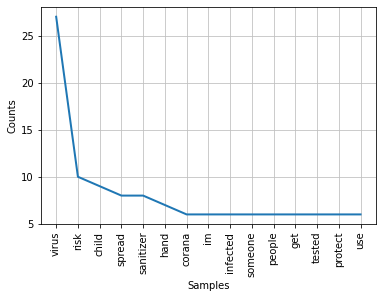


 ----- train Dataset -----
FreqDist of 408 tokens.
Top 10 common tokens: 
[('virus', 20), ('risk', 9), ('sanitizer', 7), ('protect', 6), ('someone', 6), ('spread', 6), ('hand', 6), ('child', 6), ('infected', 5), ('pet', 5)]


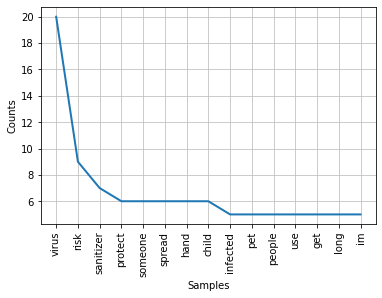


 ----- test Dataset -----
FreqDist of 102 tokens.
Top 10 common tokens: 
[('virus', 7), ('home', 4), ('child', 3), ('go', 3), ('see', 2), ('school', 2), ('isolation', 2), ('day', 2), ('spread', 2), ('tested', 2)]


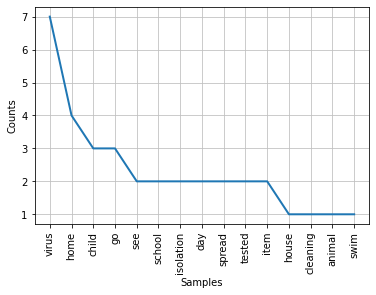

In [10]:
fqz = []
namez = ['all', 'train', 'test']
## Frequency Distributions
fqz.append( doFreqDist( list(dset.clean_data ) ) )

## @ train, test 
for i, db in enumerate([db_train, db_test]) :
    print("\n {0} {1} Dataset {0}".format("-"*5, "train" if i == 0 else "test"))
    fqz.append( doFreqDist( list(db.data ) ) )

FIN>>> shape: (30, 3), columns: Index(['token', 'freq', 'dset'], dtype='object') Sample: 
   token  freq dset
0  virus    27  all
1   risk    10  all


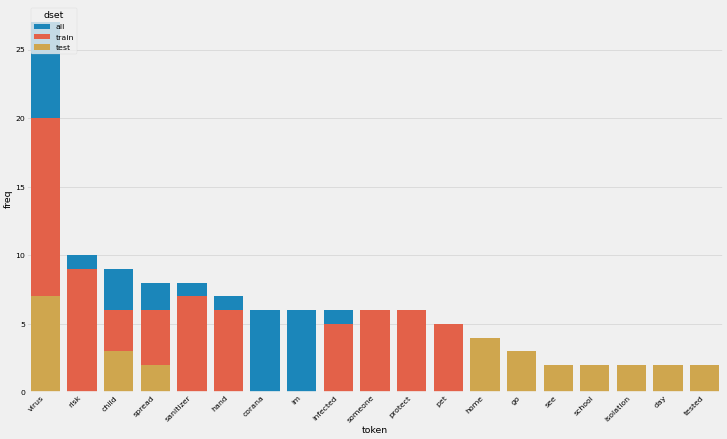

In [25]:
fq_plotMultiple( fqz, namez)